This workbook takes construction funding data from Power BI and exports summarized data

In [14]:
import os
import sys
import pandas as pd
import numpy as np
import cx_Oracle
cx_Oracle.init_oracle_client(lib_dir=r"C:\Oracle\instantclient_21_6")

ProgrammingError: Oracle Client library has already been initialized

In [63]:
#Import Funding data
Construction_details_base_df = pd.read_excel(r'FundingDetailsExport/Details_Export_Table.xlsx',sheet_name = 'Export')
Construction_Funding_df = Construction_details_base_df.copy()

C:\Users\AD21236\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [64]:
# get current month data only - manually adjust date
Construction_Funding_df = Construction_Funding_df.loc[(Construction_Funding_df['PHASE_ECD_LOGIC']>='10/1/2022') & (Construction_Funding_df['PHASE_ECD_LOGIC']<'11/1/2022'),:]

In [65]:
# Construction_Funding_df = Construction_Funding_df.loc[Construction_Funding_df['PHASE_ECD_LOGIC'] >= '1-JAN-2022',["PRIMARY_WIRE_CENTER_ID", "PHASE_ECD_LOGIC", "PHASE_NUM_OF_LUS"]].dropna(subset=["PRIMARY_WIRE_CENTER_ID"])
Construction_Funding_df = Construction_Funding_df[["PRIMARY_WIRE_CENTER_ID", "PHASE_ECD_LOGIC", "PHASE_NUM_OF_LUS"]].dropna(subset=["PRIMARY_WIRE_CENTER_ID"])
Construction_Funding_df['PHASE_ECD_LOGIC'] = Construction_Funding_df['PHASE_ECD_LOGIC'].dt.to_period('M')
Construction_Funding_df['PHASE_ECD_LOGIC'] = Construction_Funding_df['PHASE_ECD_LOGIC'].astype(str)
Construction_pivot = Construction_Funding_df.groupby(by = ["PRIMARY_WIRE_CENTER_ID","PHASE_ECD_LOGIC"], as_index = False).sum()
Construction_pivot = Construction_pivot.pivot(index='PRIMARY_WIRE_CENTER_ID', columns='PHASE_ECD_LOGIC')['PHASE_NUM_OF_LUS'].reset_index()
Construction_pivot = Construction_pivot.fillna(0)

In [66]:
# check this before manual date update below
Construction_pivot.head()

PHASE_ECD_LOGIC,PRIMARY_WIRE_CENTER_ID,2022-10
0,CLSPCOMA,653.0
1,CLSPCOPV,1342.0
2,CPCRFLXB,6115.0
3,CRYSMNCR,412.0
4,CSRKCONM,87.0


In [67]:
# manually update date
Construction_pivot['MONTH'] = Construction_pivot['2022-10']

In [68]:
Construction_pivot.head() # contains construction funded info

PHASE_ECD_LOGIC,PRIMARY_WIRE_CENTER_ID,2022-10,MONTH
0,CLSPCOMA,653.0,653.0
1,CLSPCOPV,1342.0,1342.0
2,CPCRFLXB,6115.0,6115.0
3,CRYSMNCR,412.0,412.0
4,CSRKCONM,87.0,87.0


In [69]:
# Import opportunity scores
OppScore_df = pd.read_excel(r'Inputs/CLLI_ZIP_XREF_WEIGHTED_SCORE.xlsx',sheet_name = 'Final')

# Import core status multigig readiness
MGR_df = pd.read_excel(r'Inputs/102022_OpportunityScore_MultiGig_Readiness.xlsx',sheet_name = 'Datasheet')


In [70]:
OppScore_df = OppScore_df.rename(columns = {'CLLI': 'PRIMARY_WIRE_CENTER_ID'})
OppScore_df = OppScore_df[['PRIMARY_WIRE_CENTER_ID','Weighted Opportunity Score']]

In [71]:
Construction_pivot = Construction_pivot.merge(OppScore_df, how = 'left', on = 'PRIMARY_WIRE_CENTER_ID')

In [72]:
MGR_df = MGR_df[['PRIMARY_WIRE_CENTER_ID','STATE','Core Status','Cost for Multi-Gig']]

In [73]:
Construction_final = Construction_pivot.merge(MGR_df, how = 'left', on = 'PRIMARY_WIRE_CENTER_ID')

In [74]:
Construction_final = Construction_final.rename(columns = {'Weighted Opportunity Score': 'OPPORTUNITY_SCORE',
                                     'Core Status': 'CORE_STATUS',
                                     'Cost for Multi-Gig': 'COST_FOR_MULTIGIG'})
Construction_final['CORE_STATUS'] = Construction_final['CORE_STATUS'].fillna('Not in MultiGig Readiness Worksheet')

In [75]:
Construction_final.head()

,PRIMARY_WIRE_CENTER_ID,2022-10,MONTH,OPPORTUNITY_SCORE,STATE,CORE_STATUS,COST_FOR_MULTIGIG
0,CLSPCOMA,653.0,653.0,13,CO,MultiGIG,75000.0
1,CLSPCOPV,1342.0,1342.0,10,CO,MultiGIG,150000.0
2,CPCRFLXB,6115.0,6115.0,9,FL,940M Only,75000.0
3,CRYSMNCR,412.0,412.0,13,MN,MultiGIG,50000.0
4,CSRKCONM,87.0,87.0,14,CO,MultiGIG,0.0


In [76]:
# separate into MG and non-MG data, filter out data with no opportunity score
mg_mask = (Construction_final['CORE_STATUS'] == 'MultiGIG') & (Construction_final['OPPORTUNITY_SCORE'] > 0)
non_mg_mask = (Construction_final['CORE_STATUS'] != 'MultiGIG') & (Construction_final['OPPORTUNITY_SCORE'] > 0)

MGR = Construction_final[mg_mask]
NMGR = Construction_final[non_mg_mask]

In [77]:
# Create Opportunity Score Range for MG

conditions = [
    (MGR['OPPORTUNITY_SCORE'] >= 12),
    (MGR['OPPORTUNITY_SCORE'] >= 9) & (MGR['OPPORTUNITY_SCORE'] < 12),
    (MGR['OPPORTUNITY_SCORE'] < 9)
    ]

values = ['HIGH', 'MEDIUM', 'LOW']

MGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)

C:\Windows\Temp\ipykernel_12840\1141439409.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)


In [78]:
# Create Opportunity Score Range for non-MG

conditions = [
    (NMGR['OPPORTUNITY_SCORE'] >= 12),
    (NMGR['OPPORTUNITY_SCORE'] >= 9) & (NMGR['OPPORTUNITY_SCORE'] < 12),
    (NMGR['OPPORTUNITY_SCORE'] < 9)
    ]

values = ['HIGH', 'MEDIUM', 'LOW']

NMGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)

C:\Windows\Temp\ipykernel_12840\2461150363.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NMGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)


## Code optimization start

Non-MultiGig tables outputs start here

In [79]:
NMGR_summary_combination = NMGR[["STATE","PRIMARY_WIRE_CENTER_ID","OPPORTUNITY_SCORE_TIER","MONTH"]]

In [80]:
# add wire centers count columns
NMGR_summary_combination["High Opportunity WC Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="HIGH",1,0)
NMGR_summary_combination["Medium Opportunity WC Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="MEDIUM",1,0)
NMGR_summary_combination["Low Opportunity WC Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="LOW",1,0)

# add lu count columns
NMGR_summary_combination["High Opportunity LU Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="HIGH",NMGR_summary_combination["MONTH"],0)
NMGR_summary_combination["Medium Opportunity LU Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="MEDIUM",NMGR_summary_combination["MONTH"],0)
NMGR_summary_combination["Low Opportunity LU Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="LOW",NMGR_summary_combination["MONTH"],0)


C:\Windows\Temp\ipykernel_12840\4242446084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NMGR_summary_combination["High Opportunity WC Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="HIGH",1,0)
C:\Windows\Temp\ipykernel_12840\4242446084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NMGR_summary_combination["Medium Opportunity WC Count"] = np.where(NMGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="MEDIUM",1,0)
C:\Windows\Temp\ipykernel_12840\4242446084.py:4: SettingWith

In [81]:
# sum at state level and reorder
NMGR_summary_combination = NMGR_summary_combination.groupby(['STATE'],as_index = False).sum()
NMGR_summary_combination = NMGR_summary_combination[['STATE','MONTH','High Opportunity WC Count','High Opportunity LU Count','Medium Opportunity WC Count','Medium Opportunity LU Count','Low Opportunity WC Count','Low Opportunity LU Count']].sort_values(['MONTH'], ascending = False)

In [82]:
NMGR_summary_combination # ready for export

,STATE,MONTH,High Opportunity WC Count,High Opportunity LU Count,Medium Opportunity WC Count,Medium Opportunity LU Count,Low Opportunity WC Count,Low Opportunity LU Count
0,FL,7088.0,1,628.0,2,6292.0,1,168.0
2,UT,208.0,0,0.0,1,208.0,0,0.0
1,OR,178.0,1,178.0,0,0.0,0,0.0


In [83]:
# data prep for cost-opportunity bar chart - nonMG

NMGR_costs_df = NMGR.groupby(by=["STATE", "OPPORTUNITY_SCORE_TIER"], as_index = False)['COST_FOR_MULTIGIG'].sum()
NMGR_tier_df = NMGR.groupby(["STATE", "OPPORTUNITY_SCORE_TIER"], as_index = False).size()
NMGR_LU_df = NMGR.groupby(by=["STATE", "OPPORTUNITY_SCORE_TIER"], as_index = False)["MONTH"].sum()

NMGR_Agg0_df = NMGR_tier_df.merge(NMGR_costs_df, how = 'left', on = ['STATE', 'OPPORTUNITY_SCORE_TIER'])
NMGR_Agg_df = NMGR_Agg0_df.merge(NMGR_LU_df, how = 'left', on = ['STATE', 'OPPORTUNITY_SCORE_TIER'])

# sort table

NMGR_Agg_df['OPPORTUNITY_SCORE_TIER'] = pd.Categorical(NMGR_Agg_df['OPPORTUNITY_SCORE_TIER'], ["HIGH", "MEDIUM", "LOW"])
NMGR_Agg_df.sort_values("OPPORTUNITY_SCORE_TIER", inplace = True)
NMGR_Agg_df

NMGR_Agg_df = NMGR_Agg_df.rename(columns = {'size': 'NUM_OF_WIRE_CENTERS',
                              'MONTH': 'NUM_OF_LIVING_UNITS'})

nonMG_cost_agg = NMGR_Agg_df.copy() # for export

Multigig output starts here

In [84]:
MGR.head()

,PRIMARY_WIRE_CENTER_ID,2022-10,MONTH,OPPORTUNITY_SCORE,STATE,CORE_STATUS,COST_FOR_MULTIGIG,OPPORTUNITY_SCORE_TIER
0,CLSPCOMA,653.0,653.0,13,CO,MultiGIG,75000.0,HIGH
1,CLSPCOPV,1342.0,1342.0,10,CO,MultiGIG,150000.0,MEDIUM
3,CRYSMNCR,412.0,412.0,13,MN,MultiGIG,50000.0,HIGH
4,CSRKCONM,87.0,87.0,14,CO,MultiGIG,0.0,HIGH
8,MPLSMNBE,309.0,309.0,9,MN,MultiGIG,25000.0,MEDIUM


In [85]:
MGR_summary_combination = MGR[["STATE","PRIMARY_WIRE_CENTER_ID","OPPORTUNITY_SCORE_TIER","MONTH"]]

In [86]:
# add wire centers count columns
MGR_summary_combination["High Opportunity WC Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="HIGH",1,0)
MGR_summary_combination["Medium Opportunity WC Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="MEDIUM",1,0)
MGR_summary_combination["Low Opportunity WC Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="LOW",1,0)

# add lu count columns
MGR_summary_combination["High Opportunity LU Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="HIGH",MGR_summary_combination["MONTH"],0)
MGR_summary_combination["Medium Opportunity LU Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="MEDIUM",MGR_summary_combination["MONTH"],0)
MGR_summary_combination["Low Opportunity LU Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="LOW",MGR_summary_combination["MONTH"],0)


C:\Windows\Temp\ipykernel_12840\3095379627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MGR_summary_combination["High Opportunity WC Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="HIGH",1,0)
C:\Windows\Temp\ipykernel_12840\3095379627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MGR_summary_combination["Medium Opportunity WC Count"] = np.where(MGR_summary_combination["OPPORTUNITY_SCORE_TIER"]=="MEDIUM",1,0)
C:\Windows\Temp\ipykernel_12840\3095379627.py:4: SettingWithCopy

In [87]:
# sum at state level and reorder
MGR_summary_combination = MGR_summary_combination.groupby(['STATE'],as_index = False).sum()
MGR_summary_combination = MGR_summary_combination[['STATE','MONTH','High Opportunity WC Count','High Opportunity LU Count','Medium Opportunity WC Count','Medium Opportunity LU Count','Low Opportunity WC Count','Low Opportunity LU Count']].sort_values(['MONTH'], ascending = False)

In [88]:
MGR_summary_combination # ready for export

,STATE,MONTH,High Opportunity WC Count,High Opportunity LU Count,Medium Opportunity WC Count,Medium Opportunity LU Count,Low Opportunity WC Count,Low Opportunity LU Count
1,CO,2176.0,3,834.0,1,1342.0,0,0.0
2,MN,1326.0,3,1017.0,1,309.0,0,0.0
0,AZ,1277.0,0,0.0,0,0.0,1,1277.0
4,WA,757.0,1,262.0,2,495.0,0,0.0
3,UT,543.0,1,543.0,0,0.0,0,0.0


In [90]:
# export

import time

TodaysDate = time.strftime("%m%d%y")
excelfilename = "Output/" + TodaysDate +"_ConstructionFunded_Monthly_Data.xlsx"

with pd.ExcelWriter(excelfilename) as writer: 
    MGR_summary_combination.to_excel(writer, sheet_name='MG', index = False)
    NMGR_summary_combination.to_excel(writer, sheet_name='NonMG', index = False)
    nonMG_cost_agg.to_excel(writer, sheet_name='NonMG_Cost_Summary', index = False)
    Construction_final.to_excel(writer, sheet_name='Details', index = False)
    Construction_details_base_df.to_excel(writer, sheet_name='FundingOriginalExport', index = False)

Graph for MultiGig - Wire Center Details

In [91]:
MGR.head()

,PRIMARY_WIRE_CENTER_ID,2022-10,MONTH,OPPORTUNITY_SCORE,STATE,CORE_STATUS,COST_FOR_MULTIGIG,OPPORTUNITY_SCORE_TIER
0,CLSPCOMA,653.0,653.0,13,CO,MultiGIG,75000.0,HIGH
1,CLSPCOPV,1342.0,1342.0,10,CO,MultiGIG,150000.0,MEDIUM
3,CRYSMNCR,412.0,412.0,13,MN,MultiGIG,50000.0,HIGH
4,CSRKCONM,87.0,87.0,14,CO,MultiGIG,0.0,HIGH
8,MPLSMNBE,309.0,309.0,9,MN,MultiGIG,25000.0,MEDIUM


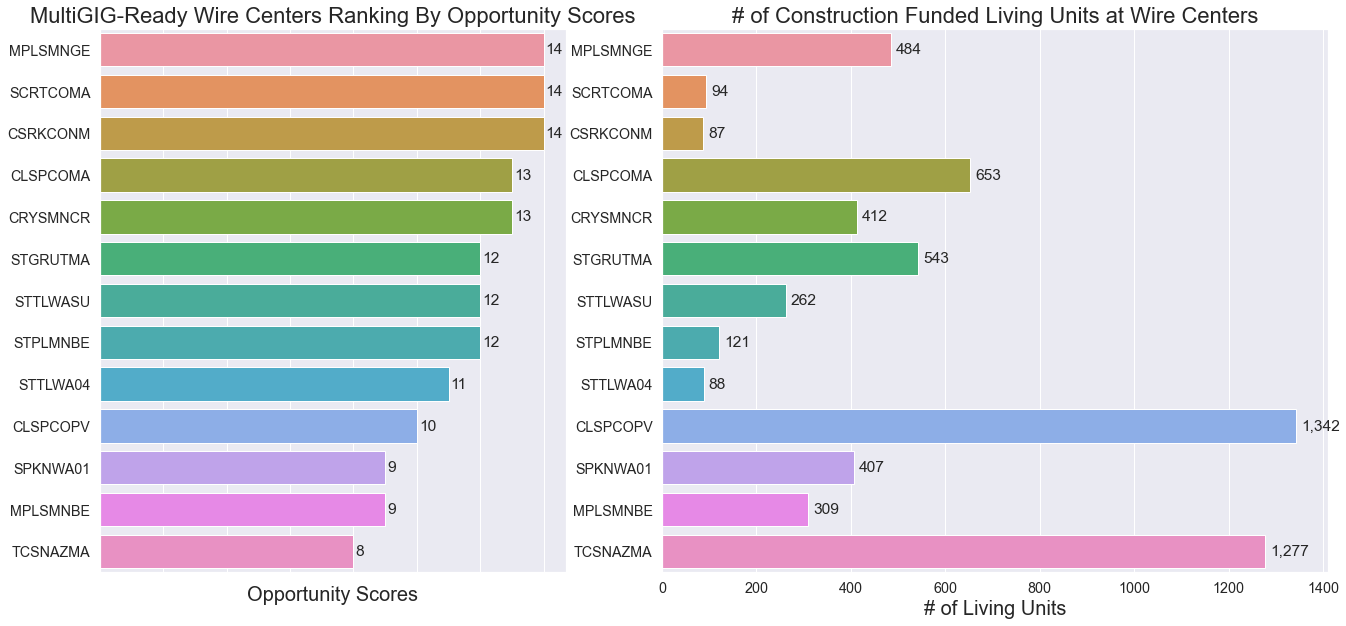

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# set graph space

fig2, (ax2, ax3) = plt.subplots(1,
                                2, 
                                figsize = (22, 10), 
                                gridspec_kw = {'width_ratios': [1.4, 2]})

# set opportunity score tier
opp_mask = (MGR["OPPORTUNITY_SCORE_TIER"] == "HIGH")|(MGR["OPPORTUNITY_SCORE_TIER"] == "MEDIUM")|(MGR["OPPORTUNITY_SCORE_TIER"] == "LOW")

# create graph
sns.set(font_scale = 1.3)
sns.barplot(x = "OPPORTUNITY_SCORE", 
            y = "PRIMARY_WIRE_CENTER_ID", 
            data = MGR[opp_mask].sort_values(by = ['OPPORTUNITY_SCORE', 'MONTH', 'PRIMARY_WIRE_CENTER_ID'], ascending = False),
            orient = 'h',
            ax = ax2).set(xticklabels = [])
sns.barplot(x = "MONTH", 
            y = "PRIMARY_WIRE_CENTER_ID", 
            #data=MultiGIG_df[:20].sort_values(by = ['Opportunity Score', 'WIRE_CENTER_ID'], ascending = False),
            data = MGR[opp_mask].sort_values(by = ['OPPORTUNITY_SCORE', 'MONTH', 'PRIMARY_WIRE_CENTER_ID'], ascending = False),
            orient = 'h',
            ax = ax3)

plt.subplots_adjust(wspace=.17, hspace=0)

# set axis properties ax2

ax2.set_title('MultiGIG-Ready Wire Centers Ranking By Opportunity Scores', fontsize = 22)
ax2.set(xlabel='Opportunity Scores', ylabel='')
ax2.xaxis.label.set_size(20)

# label value on bars
for i in ax2.containers:
    ax2.bar_label(i,
                 padding=2)

# set axis properties ax3

ax3.set_title('# of Construction Funded Living Units at Wire Centers', fontsize = 22)
ax3.set(xlabel='# of Living Units', ylabel='')
ax3.xaxis.label.set_size(20)

for i in ax3.containers:
    ax3.bar_label(i, 
                  labels=[f'{x:,.0f}' for x in i.datavalues], 
                  padding=5)
    
plt.show()    

# plt.savefig('Output/Graphs/MultiGIG-Ready_WC_Ranked_By_OppScores_LUs.png')
# plt.savefig('Output/Graphs/test.png')